## 1. Introduction

NASA Space Apps Challenge hackathon which was held in 2017 asked participants to predict the amount solar radiation using a set of measurable metoeorological conditions. The NASA HI-SEAS(Hawaii Space Exploration Analog and Simulation) site where provided the solar radiation dataset simulates a human settlement on Mars. 
<br>
The main power source in the settlement is obtained from a large solar array and battery bank. The prediction of solar radiaiton will help to decide when or where to deploy solar energy harvesting equipment.The can be found in Kaggle:https://www.kaggle.com/dronio/SolarEnergy 


## 2. About this dataset

The meteorlogical data from the dataset is from the HI-SEAS station from September through December 2016. The size of the dataset is 2.82 MB and 11 columns. It is consists of date and time and numerical formats. 

The units and formats of each dataset are:

* UNIX time_t date: seconds since Jan 1, 197

* Date: yyyy-mm-dd format

* Local time of day in hh:mm:ss: 24-hour format

* Solar radiation: watts per meter^2

* Temperature: degrees Fahrenheit

* Humidity: percent

* Barometric pressure: Hg

* Wind direction: degrees

* Wind speed: miles per hour

* Sunrise/sunset: Hawaii time


## 3. Data Exploration and Analysis

A feature engineering is conducted to get meaningful features from the date and time columns and remove unecessary features. Afterward I removed the missing values and outliers using an interquartile range. Linear Regression, Lasso, Random Forest and Extra Trees models are used to predict the solar radiation and the scores of mse and r-squared were utilized to evaluate models. 

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from yellowbrick.regressor import ResidualsPlot, PredictionError

In [185]:
df = pd.read_csv('SolarPrediction.csv')
# for i in ['Time','TimeSunRise','TimeSunSet']:
#     df[i] = pd.to_timedelta(df[i]).dt.total_seconds().astype(float)

In [186]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


## Feature Engineering

In [187]:
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
df['UNIXTime'] =  pd.to_datetime(df['UNIXTime'], unit='s')
df['DayofYear'] =pd.DatetimeIndex(df['UNIXTime']).dayofyear
df['TimeSunRise'] = pd.to_datetime(df['TimeSunRise'], format='%H:%M:%S')
df['TimeSunSet'] = pd.to_datetime(df['TimeSunSet'], format='%H:%M:%S')
df['DayLength(s)'] = df['TimeSunSet'].dt.hour*60*60 \
                           + df['TimeSunSet'].dt.minute*60 \
                           + df['TimeSunSet'].dt.second \
                           - df['TimeSunRise'].dt.hour*60*60 \
                           - df['TimeSunRise'].dt.minute*60 \
                           - df['TimeSunRise'].dt.second
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'], axis=1, inplace=True)

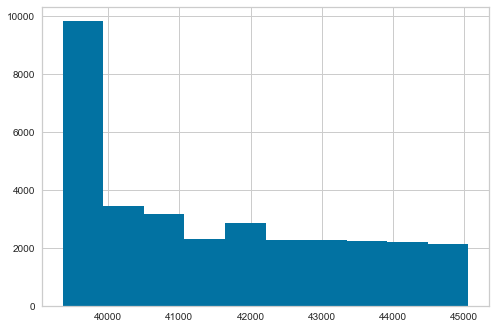

In [188]:
df['DayLength(s)'].hist()

In [134]:
df.head()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Data_UnixTimeStamp,TimeSunRise_UnixTimeStamp,TimeSunSet_UnixTimeStamp,SunTime
0,1.21,48,30.46,59,177.39,5.62,1475218526,1475154780,1475197980,43200
1,1.21,48,30.46,58,176.78,3.37,1475218223,1475154780,1475197980,43200
2,1.23,48,30.46,57,158.75,3.37,1475217926,1475154780,1475197980,43200
3,1.21,48,30.46,60,137.71,3.37,1475217621,1475154780,1475197980,43200
4,1.17,48,30.46,62,104.95,5.62,1475217324,1475154780,1475197980,43200


## Find and remove outliers

In [4]:
len(df)

32686

In [5]:
df.dropna(inplace=True)
len(df)

32686

In [135]:
df.describe()

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Data_UnixTimeStamp,TimeSunRise_UnixTimeStamp,TimeSunSet_UnixTimeStamp,SunTime
count,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,32686.000000,3.268600e+04,3.268600e+04,3.268600e+04,32686.000000
mean,207.124697,51.103255,30.422879,75.016307,143.489821,6.243869,1.478038e+09,1.478018e+09,1.478060e+09,41433.032491
std,315.916387,6.201157,0.054673,25.990219,83.167500,3.490474,3.006572e+06,3.007560e+06,3.005803e+06,1795.873502
min,1.110000,34.000000,30.190000,8.000000,0.090000,0.000000,1.472713e+09,1.472735e+09,1.472780e+09,39360.000000
25%,1.230000,46.000000,30.400000,56.000000,82.227500,3.370000,1.475536e+09,1.475500e+09,1.475543e+09,39720.000000
50%,2.660000,50.000000,30.430000,85.000000,147.700000,5.620000,1.478015e+09,1.478007e+09,1.478048e+09,41040.000000
75%,354.235000,55.000000,30.460000,97.000000,179.310000,7.870000,1.480473e+09,1.480430e+09,1.480470e+09,42900.000000
max,1601.260000,71.000000,30.560000,103.000000,359.950000,40.500000,1.483257e+09,1.483196e+09,1.483236e+09,45060.000000


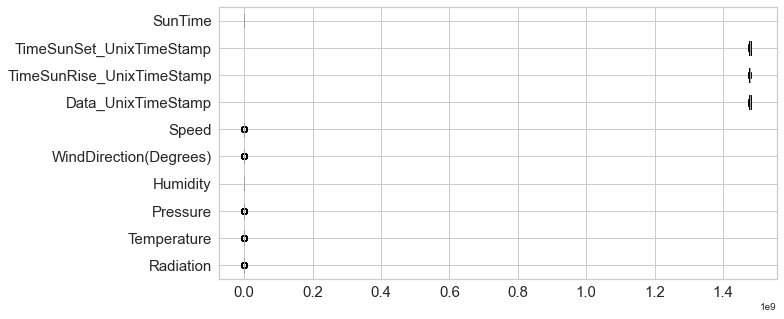

In [136]:
_=df.boxplot(grid=True, vert=False,fontsize=15,figsize=(10,5))

27502

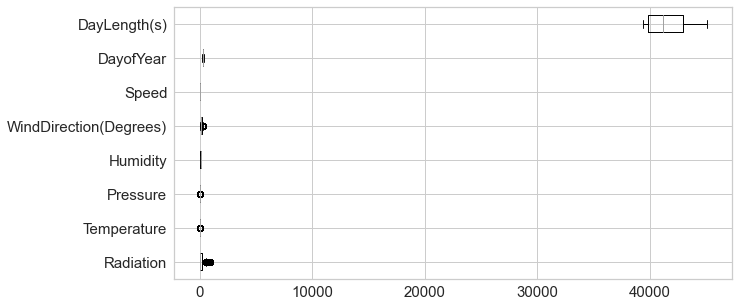

In [18]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR =Q3 - Q1
dfno =  df[~((df < (Q1 - 1.5 * IQR)) |(df> (Q3 + 1.5 * IQR))).any(axis=1)]
_ =dfno.boxplot(grid=True, vert=False,fontsize=15, figsize=(10,5))
len(dfno)

In [100]:
df =dfno

## Correlation Matrix

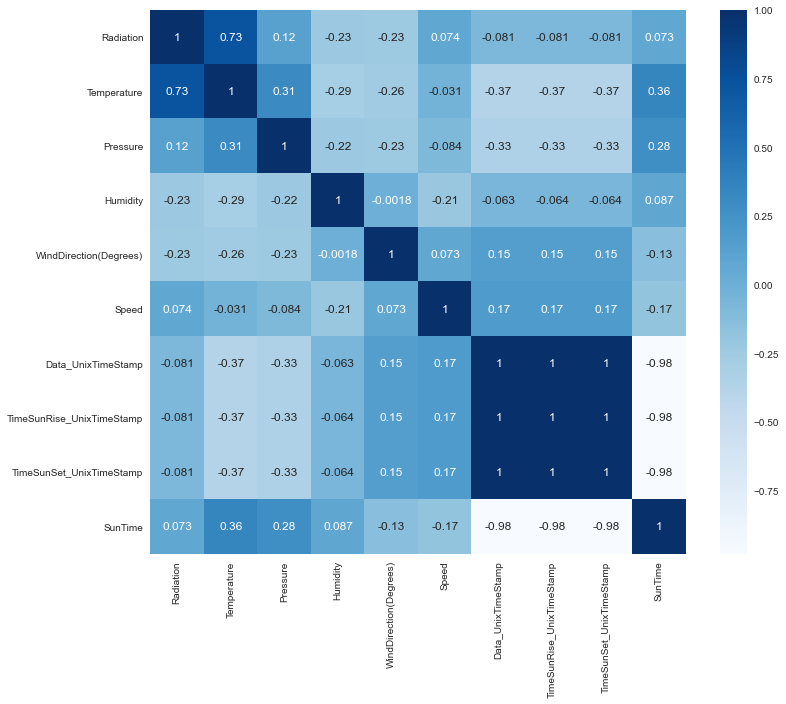

In [137]:
plt.figure(figsize=(12,10))
p=sns.heatmap(df.corr(), annot=True,cmap ='Blues')

In [193]:
X = df.drop(['Radiation'],axis=1)

In [194]:
y = df.Radiation
y = y.ravel()

In [195]:
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)

In [196]:
X_train.min(),X_train.min()

(0.0, 0.0)

In [197]:
X_train= preprocessing.scale(X_train)
X_test= preprocessing.scale(X_test)

## Linear Regression
### 1) Fit a linear regression model

In [198]:
def sklearnfit(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    mse_test = metrics.mean_squared_error(y_test, pred_test)
    mse_train = metrics.mean_squared_error(y_train, pred_train)
    r2 = metrics.r2_score(y_test, pred_test)
    print(f'MSE_Train:{round(mse_train,4)}, MSE_Test:{round(mse_test,4)}, R2:{round(r2,4)}')
    return model
model1 = sklearnfit(LinearRegression(),X_train, X_test, y_train, y_test)

MSE_Train:39551.4142, MSE_Test:40522.1763, R2:0.6037


###  2) Evaluate a model

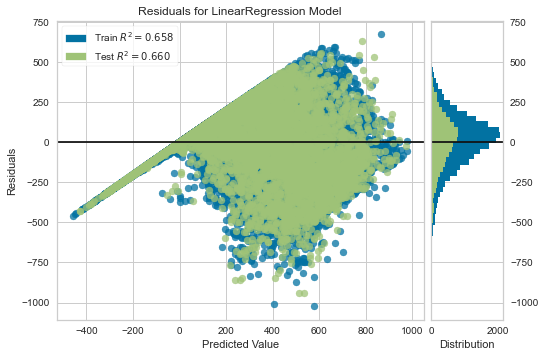

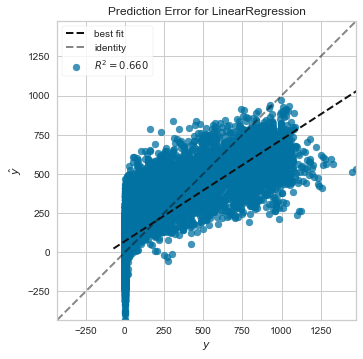

In [151]:
def drawplot(model):
    plots=[ResidualsPlot(model),PredictionError(model)]
    for i in plots:
        i.fit(X_train, y_train)
        i.score(X_test, y_test)
        _=i.show()
drawplot(model1)

### 3) Statistical modeling

In [152]:
def olsfunc(X_train,y_train):
    X_ols = sm.add_constant(X_train)
    model_ols = sm.OLS(y_train,X_ols)
    res = model_ols.fit()
    return res, res.summary()
statsmodel, statsmodelsummary= olsfunc(X_train,y_train)
statsmodelsummary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Radiation   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     5502.
Date:                Thu, 17 Sep 2020   Prob (F-statistic):               0.00
Time:                        15:52:12   Log-Likelihood:            -1.5175e+05
No. Observations:               22880   AIC:                         3.035e+05
Df Residuals:                   22871   BIC:                         3.036e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.902e+12   5.79e+10    -50.092      0.000   -3.02e+12   -2.79e+12
x1          8.637e+10   7.99e+08    108.146      0.000    8.48e+10    8.79e+10
x2         -5.069e+11   5.97e+10     -8.489      0.000   -6.24e+11    -3.9e+11
x3          2.623e+07   1.38e+08      0.189      0.850   -2.45e+08    2.98e+08
x4         -5.474e+08   3.98e+07    -13.742      0.000   -6.25e+08   -4.69e+08
x5          1.287e+10   9.34e+08     13.790      0.000     1.1e+10    1.47e+10
x6          1.676e+12   3.35e+10     50.092      0.000    1.61e+12    1.74e+12
x7          1.676e+12   3.34e+10     50.093      0.000    1.61e+12    1.74e+12
x8          1.676e+12   3.35e+10     50.091      0.000    1.61e+12    1.74e+12
x9          1.258e+07   2.23e+06      5.635      0.000    8.21e+06     1.7e+07
==============================================================================
Omnibus:                     1558.770   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2297.879
Skew:                           0.572   Prob(JB):                         0.00
Kurtosis:                       4.050   Cond. No.                     1.63e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.72e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [122]:
df1 = pd.DataFrame(abs(statsmodel.params[1:]), X.columns,columns=['Coefficient'])
df1.sort_values(by = 'Coefficient',ascending=False).head(10)

,Coefficient
Temperature,158.950458
DayLength(s),135.920870
WindDirection(Degrees),103.816980
DayofYear,87.131016
Speed,23.682422
Pressure,19.391266
Humidity,9.083429


## Lasso regression

In [123]:
X = df.drop(['Radiation'],axis=1)
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)
X_train= preprocessing.scale(X_train)
X_test= preprocessing.scale(X_test)
lasso_model = Lasso(random_state=123)
model_lasso = sklearnfit(lasso_model,X_train, X_test, y_train, y_test)


MSE_Train:27146.2822, MSE_Test:27257.7288, R2:0.5618


## RandomForest 

In [124]:
from sklearn.ensemble import RandomForestRegressor
X = df.drop(['Radiation'],axis=1)
X_nol = preprocessing.normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_nol, y, test_size=0.3,random_state=123)
rfmodel = RandomForestRegressor(n_estimators = 100)
rfmodel_fit = sklearnfit(rfmodel,X_train, X_test, y_train, y_test)

MSE_Train:1397.1267, MSE_Test:9714.9794, R2:0.8438


## ExtraTrees

In [153]:
from sklearn.ensemble import ExtraTreesRegressor
extra_model = ExtraTreesRegressor(random_state=123)
extramodel_fit = sklearnfit(extra_model,X_train, X_test, y_train, y_test)

MSE_Train:5664.5757, MSE_Test:14742.4236, R2:0.8558
